In [1]:
%matplotlib notebook
%matplotlib inline

import os
import time
import datetime as dt
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader
import stock_data_preprocessing

# Load newest Google stock data from Yahoo Finance

In [2]:
#load data
start = dt.datetime(1995,1,1)
end   = dt.date.today()
data = pandas_datareader.data.DataReader('GOOG','yahoo',start,end)
data.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,100.000168,104.060182,95.960165,100.340176,44871300,50.119968
2004-08-20,101.010175,109.080187,100.500174,108.310183,22942800,54.100990
2004-08-23,110.750191,113.480193,109.050183,109.400185,18342800,54.645447
2004-08-24,111.240189,111.600192,103.570177,104.870176,15319700,52.382705
2004-08-25,104.960181,108.000187,103.880180,106.000184,9232100,52.947145


In [3]:
# dataset on local machine
md = pd.read_csv('mdjt_prices.csv', encoding="GBK")

In [4]:
md_data = md[['closePrice', 'turnoverVol']]

# Normalise and Prepozess the data like a boss^12

In [5]:
#normalise data
data_n = stock_data_preprocessing.normalise_stock_data(data)
data_n.head(1)


,Ordinal/1e6,Weekday,Adj Volume,Adj Close,Adj Open,Adj High,Adj Low,Normalised Volume,Normalised Close,Normalised Open,Normalised High,Normalised Low
Date,,,,,,,,,,,,
2004-08-19,0.731812,3.0,0.543621,1.0,0.996611,1.037074,0.956348,0.0,0.0,0.0,0.0,0.0


In [6]:
len(data_n.columns)

12

# 1,2,3 Plot Line!

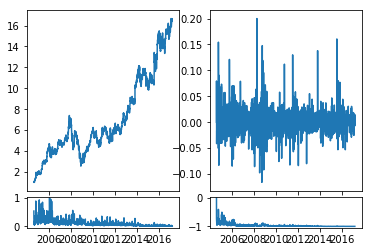

In [7]:
stock_data_preprocessing.stock_plot((data_n,))

# Pickup the Data

In [8]:
# training data
prediction_time = 1 #day
testdatasize = 450
unroll_length = 50                                     # sequence length = seq_len = 50
testdatacut = testdatasize + unroll_length  + 1

x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ]['Normalised Close'].as_matrix()

# validation data


# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ]['Normalised Close'].as_matrix()



In [9]:
print(x_train[0:2])
print(y_train[0:2])

[[  7.31812000e-01   3.00000000e+00   5.43621088e-01   1.00000000e+00
    9.96611447e-01   1.03707394e+00   9.56348382e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  7.31813000e-01   4.00000000e+00   2.77954726e-01   1.07942986e+00
    1.00667727e+00   1.08710379e+00   1.00159455e+00  -7.22045274e-01
    7.94298592e-02   6.67726667e-03   8.71037942e-02   1.59454691e-03]]
[ 0.07942986  0.01006372]


# unroll it

In [10]:
                                                    # unroll func add a seq_len to arrays like x_train, y_train
                                                    # 2-d array will become 3-d array
def unroll(data,sequence_length=2):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)


x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
print(x_train.shape[0])
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

print('now 2-d arrays becomes 3-d arrays: dim of x_train, x_test: (num_data_points, seq_len, num_features)')
print("x_train", x_train.shape)
print("x_test", x_test.shape)
print(" ")
print('y_train and y_test dim stays the same')
print("y_train", y_train.shape)
print("y_test", y_test.shape)

2605
now 2-d arrays becomes 3-d arrays: dim of x_train, x_test: (num_data_points, seq_len, num_features)
x_train (2605, 50, 12)
x_test (450, 50, 12)
 
y_train and y_test dim stays the same
y_train (2605,)
y_test (450,)


# Save dataset into Jsonl files

In [17]:
name = []
with open('data/train.jsonl', 'w') as outfile:

    outfile.write(json.dumps({
        'features': x_train.tolist(),    # write into file as list of list rather than numpy arrays
        'prices': y_train.tolist()   # QUESTION: it means kur accept lists from jsonl file by default
    }))
    outfile.write('\n')

with open('data/test.jsonl', 'w') as outfile:

    outfile.write(json.dumps({
        'features': x_test.tolist(),    # write into file as list of list rather than numpy arrays
        'prices': y_test.tolist()   # QUESTION: it means kur accept lists from jsonl file by default
    }))
    outfile.write('\n')

# Go! (with Python 3.5, Keras 1.2.2 and Tensorflow 1.0, better on AWS)

In [11]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

Using Theano backend.


In [12]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],                 # input layer dim == num_neurons of input layer == num_features of input data
    output_dim=50,                               # h1_layer dim == 50, set by user
    return_sequences=True))                      # every value on the sequence will pass an output
model.add(Dropout(0.2))

model.add(LSTM(
    100,                                         # h2_layer dim = 100, set by user
    return_sequences=False))                     # last value on the sequence will pass an output
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))                               # dense_layer or output layer dim = 1, 
                                                 # a sequence of values only to predice one price
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.01160883903503418


In [13]:
#Step 3 Train the model
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=3,
    validation_split=0.05)

Train on 2474 samples, validate on 131 samples
Epoch 1/3
2474/2474 [==============================] - 9s - loss: 0.3636 - val_loss: 1.0946
Epoch 2/3
2474/2474 [==============================] - 7s - loss: 1.2165 - val_loss: 0.0017
Epoch 3/3
2474/2474 [==============================] - 7s - loss: 0.0720 - val_loss: 0.0198


# Same Model & some (~ x10) fewer Loss !!! :) 

yo


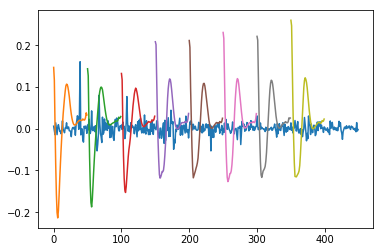

In [14]:
#Step 4 - Plot the predictions!
import lstm
predictions = lstm.predict_sequences_multiple(model, x_test, 50, 50)
lstm.plot_results_multiple(predictions, y_test, 50)

In [27]:
%%writefile stock_rnn_kur.yaml

---







model:
  - input: features


  - recurrent:
    size: 50
    type: lstm
    sequence: yes
    bidirectional: no
  - batch_normalization

  - recurrent:
      size: 100
      type: lstm
      sequence: no
      bidirectional: no

  - dense: 1

  - activation: relu

  - output: prices

loss:
  - target: prices
    name: mean_squared_error

train:
  data:
    - jsonl: data/train.jsonl
  epochs: 2                               
  weights:
    initial: t1/best.w.kur
    best: t1/best.w.kur
    last: t1/last.w.kur
  log: t1/log
  hooks:                                   # Let plot loss
    - plot: t1/loss.png


validate:
  data:
    - jsonl: data/test.jsonl
  weights: t1/best.w.kur


test:
  data:
    - jsonl: data/test.jsonl
  weights: t1/best.w.kur


evaluate:
  data:
    - jsonl: data/test.jsonl
  weights: t1/best.w.kur

  destination: t1/output.pkl
...

Overwriting stock_rnn_kur.yaml


In [1]:
!kur -v train stock_rnn_kur.yaml

[INFO 2017-03-06 19:58:04,674 kur.kurfile:699] Parsing source: stock_rnn_kur.yaml, included by top-level.
[INFO 2017-03-06 19:58:04,682 kur.kurfile:82] Parsing Kurfile...
Traceback (most recent call last):
  File "/Users/Natsume/miniconda2/envs/dlnd-tf-lab/bin/kur", line 11, in <module>
    load_entry_point('kur', 'console_scripts', 'kur')()
  File "/Users/Natsume/Downloads/kur_road/kur/kur/__main__.py", line 382, in main
    sys.exit(args.func(args) or 0)
  File "/Users/Natsume/Downloads/kur_road/kur/kur/__main__.py", line 60, in train
    spec = parse_kurfile(args.kurfile, args.engine)
  File "/Users/Natsume/Downloads/kur_road/kur/kur/__main__.py", line 46, in parse_kurfile
    spec.parse()
  File "/Users/Natsume/Downloads/kur_road/kur/kur/kurfile.py", line 124, in parse
    self.engine, builtin['model'], stack, required=True)
  File "/Users/Natsume/Downloads/kur_road/kur/kur/kurfile.py", line 657, in _parse_model
    container.parse(engine)
  File "/Users/Natsume/Downloads/kur_road/